# (6m)Amplitudes

author: steeve.laquitaine@epfl.ch  
last modified:  22.07.2024  
status: up-to-date

## (7s)Setup

In [1]:
# import libs
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

import os
import multiprocessing
import torch
import numpy as np
from matplotlib import pyplot as plt
import spikeinterface as si
import seaborn as sns
import pandas as pd
import matplotlib

# move to PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config, get_stats_config, standardize_layers
from src.nodes.validation import amplitude as amp

SF_V = 20000
SF_S = 20000

# denser probe (horvath)  ------
# vivo (probe 1)
cfg_hv1, _ = get_config("vivo_horvath", "probe_1").values()
PREP_PATH_hv1 = cfg_hv1["preprocessing"]["full"]["output"]["trace_file_path"]
# probe 2
cfg_hv2, _ = get_config("vivo_horvath", "probe_2").values()
PREP_PATH_hv2 = cfg_hv2["preprocessing"]["full"]["output"]["trace_file_path"]
# probe 3
cfg_hv3, _ = get_config("vivo_horvath", "probe_3").values()
PREP_PATH_hv3 = cfg_hv3["preprocessing"]["full"]["output"]["trace_file_path"]

# biophy. model
# (probe 1)
cfg_hs1, _ = get_config("dense_spont", "probe_1").values()
PREP_PATH_hs1 = cfg_hs1["preprocessing"]["full"]["output"]["trace_file_path"]
# probe 2
cfg_hs2, _ = get_config("dense_spont", "probe_2").values()
PREP_PATH_hs2 = cfg_hs2["preprocessing"]["full"]["output"]["trace_file_path"]
# probe 3
cfg_hs3, _ = get_config("dense_spont", "probe_3").values()
PREP_PATH_hs3 = cfg_hs3["preprocessing"]["full"]["output"]["trace_file_path"]

# pipeline parameters
SAVE_FIG = False
SAVE_TEMP_DATA = False
LOAD_TEMP_DATA = True

# save paths
PLOT_DATA_PATH = get_stats_config()["fig2o_data_peak_amplitudes_dense"]


# Figure settings
COLOR_HV = [0.3, 0.3, 0.3]
COLOR_HS = np.array([26, 152, 80]) / 255 # green

cl = dict()
cl["COLOR_HV"] = "k" # black
cl["COLOR_HS"] = np.array([26, 152, 80]) / 255 # green

# axes
FIG_SIZE = (1.7, 1)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5 # minimum in literature
plt.rcParams["axes.linewidth"] = 0.5 #1
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1
# legend
savefig_cfg = {"transparent":True, "dpi":300}
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}
LG_FRAMEON = False              # no legend frame
savefig_cfg = {"transparent":True, "dpi": 300}

2024-12-09 10:03:54,802 - root - utils.py - get_config - INFO - Reading experiment config.
2024-12-09 10:03:54,873 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-12-09 10:03:54,874 - root - utils.py - get_config - INFO - Reading experiment config.
2024-12-09 10:03:54,905 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-12-09 10:03:54,906 - root - utils.py - get_config - INFO - Reading experiment config.
2024-12-09 10:03:54,967 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-12-09 10:03:54,968 - root - utils.py - get_config - INFO - Reading experiment config.
2024-12-09 10:03:55,012 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-12-09 10:03:55,013 - root - utils.py - get_config - INFO - Reading experiment config.
2024-12-09 10:03:55,056 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-12-09 10:03:55,057 - root - utils.py - get_config 

## Specs

In [2]:
# cpus, gpu and current memory usage
print("available cpus:", multiprocessing.cpu_count())
print("available gpus:", torch.cuda.is_available())
%system free -m

available cpus: 72
available gpus: True


['              total        used        free      shared  buff/cache   available',
 'Mem:         772341       24368      746248         175        1723      746230',
 'Swap:             0           0           0']

## (1s)Load datasets

* first 10 minutes

In [2]:
# 1 - Load silico and vivo traces, select 10 min
# horvath
# probe 1, 2, 3
RecHS1 = si.load_extractor(PREP_PATH_hs1)
RecHV1 = si.load_extractor(PREP_PATH_hv1)
RecHS2 = si.load_extractor(PREP_PATH_hs2)
RecHV2 = si.load_extractor(PREP_PATH_hv2)
RecHS3 = si.load_extractor(PREP_PATH_hs3)
RecHV3 = si.load_extractor(PREP_PATH_hv3)

# 3. get traces
# horvath
traces_hs1 = RecHS1.get_traces()
traces_hv1 = RecHV1.get_traces()
traces_hs2 = RecHS2.get_traces()
traces_hv2 = RecHV2.get_traces()
traces_hs3 = RecHS3.get_traces()
traces_hv3 = RecHV3.get_traces()

# 4 - get good sites (in cortex)
# neuropixels
lyrs = ["L1", "L2/3", "L4", "L5", "L6"]

# horvath
# silico
# probe 1 (select L1, L2/3)
site_ly_hs1 = RecHS1.get_property("layers")
site_ly_hs1 = standardize_layers(site_ly_hs1)
#site_ly_hs1 = np.array(["L2/3" if x == "L2" or x == "L3" else x for x in site_ly_hs1])
#site_ly_hs1 = np.array(["L2/3" if x == "L2_3" else x for x in site_ly_hs1])
sites_hs1 = np.where(np.isin(site_ly_hs1, ["L1", "L2/3"]))[0]
# probe 2 (select L4 and L5)
site_ly_hs2 = RecHS2.get_property("layers")
site_ly_hs2 = standardize_layers(site_ly_hs2)
sites_hs2 = np.where(np.isin(site_ly_hs2, ["L4", "L5"]))[0]
# probe 3 (select L6)
site_ly_hs3 = RecHS3.get_property("layers")
site_ly_hs3 = standardize_layers(site_ly_hs3)
#site_ly_hs3 = np.array(["L2/3" if x == "L2" or x == "L3" else x for x in site_ly_hs3])
#site_ly_hs3 = np.array(["L2/3" if x == "L2_3" else x for x in site_ly_hs3])
sites_hs3 = np.where(np.isin(site_ly_hs3, ["L6"]))[0]

# vivo
# probe 1 (select L1, L2/3)
site_ly_hv1 = RecHV1.get_property("layers")
site_ly_hv1 = standardize_layers(site_ly_hv1)
#site_ly_hv1 = np.array(["L2/3" if x == "L2_3" else x for x in site_ly_hv1])
sites_hv1 = np.where(np.isin(site_ly_hv1, ["L1", "L2/3"]))[0]
# probe 2 (select L4, L5)
site_ly_hv2 = RecHV2.get_property("layers")
site_ly_hv2 = standardize_layers(site_ly_hv2)
sites_hv2 = np.where(np.isin(site_ly_hv2, ["L4", "L5"]))[0]
# probe 3 (select L6)
site_ly_hv3 = RecHV3.get_property("layers")
site_ly_hv3 = standardize_layers(site_ly_hv3)
sites_hv3 = np.where(np.isin(site_ly_hv3, ["L6"]))[0]

## (2.5m)Report amplitudes

In [4]:
# depth 1
print("\nDepth 1:\n")
print("Horvath depth 1:", np.max(np.absolute(traces_hv1[:, sites_hv1])))
print("Horvath depth 1 (all sites):", np.max(np.absolute(traces_hv1)))
print("Biophy. dense probe depth 1:", np.max(np.absolute(traces_hs1[:, sites_hs1])))
print(
    "Biophy. dense probe depth 1 (all sites):",
    np.max(np.absolute(traces_hs1)),
)

# depth 2
print("\nDepth 2:\n")
print("Horvath depth 2:", np.max(np.absolute(traces_hv2[:, sites_hv2])))
print("Horvath depth 2 (all sites):", np.max(np.absolute(traces_hv2)))
print("Biophy. dense probe depth 2:", np.max(np.absolute(traces_hs2[:, sites_hs2])))
print(
    "Biophy. dense probe depth 2 (all sites):",
    np.max(np.absolute(traces_hs2)),
)

# depth 3
print("\nDepth 3:\n")
print("Horvath depth 3:", np.max(np.absolute(traces_hv3[:, sites_hv3])))
print("Horvath depth 3 (all sites):", np.max(np.absolute(traces_hv3)))
print("Biophy. dense probe depth 3:", np.max(np.absolute(traces_hs3[:, sites_hs3])))
print(
    "Biophy. dense probe depth 3 (all sites):",
    np.max(np.absolute(traces_hs3)),
)


Depth 1:

Horvath depth 1: 4129
Horvath depth 1 (all sites): 4129
Biophy. dense probe depth 1: 4203.636
Biophy. dense probe depth 1 (all sites): 4203.636

Depth 2:

Horvath depth 2: 3743
Horvath depth 2 (all sites): 3743
Biophy. dense probe depth 2: 3738.2268
Biophy. dense probe depth 2 (all sites): 3738.2268

Depth 3:

Horvath depth 3: 3390
Horvath depth 3 (all sites): 4063
Biophy. dense probe depth 3: 3277.8064
Biophy. dense probe depth 3 (all sites): 3928.0789


## (10m)Compute

In [ ]:
# compute max per site
# vivo
maxs_hv1 = np.absolute(traces_hv1[:, sites_hv1]).max(axis=0)
maxs_hv2 = np.absolute(traces_hv2[:, sites_hv2]).max(axis=0)
maxs_hv3 = np.absolute(traces_hv3[:, sites_hv3]).max(axis=0)

# biophy
maxs_hs1 = np.absolute(traces_hs1[:, sites_hs1]).max(axis=0)
maxs_hs2 = np.absolute(traces_hs2[:, sites_hs2]).max(axis=0)
maxs_hs3 = np.absolute(traces_hs3[:, sites_hs3]).max(axis=0)

# Format plot data

# vivo
# L1, 2/3
df1 = pd.DataFrame()
df1["amplitude"] = maxs_hv1[
    (np.array(site_ly_hv1)[sites_hv1] == "L1") | (np.array(site_ly_hv1)[sites_hv1] == "L2/3")
]
df1["layer"] = np.array(site_ly_hv1)[sites_hv1][
    (np.array(site_ly_hv1)[sites_hv1] == "L1") | (np.array(site_ly_hv1)[sites_hv1] == "L2/3")
]
df1["experiment"] = "Dense (Horvath)"
df1 = df1.sort_values(by="layer")

# L4, L5
df2 = pd.DataFrame()
df2["amplitude"] = maxs_hv2[
    (np.array(site_ly_hv2)[sites_hv2] == "L4") | (np.array(site_ly_hv2)[sites_hv2] == "L5")
]
df2["layer"] = np.array(site_ly_hv2)[sites_hv2][
    (np.array(site_ly_hv2)[sites_hv2] == "L4") | (np.array(site_ly_hv2)[sites_hv2] == "L5")
]
df2["experiment"] = "Dense (Horvath)"
df2 = df2.sort_values(by="layer")

# L6
df3 = pd.DataFrame()
df3["amplitude"] = maxs_hv3[
    (np.array(site_ly_hv3)[sites_hv3] == "L6") | (np.array(site_ly_hv3)[sites_hv3] == "L6")
]
df3["layer"] = np.array(site_ly_hv3)[sites_hv3][
    (np.array(site_ly_hv3)[sites_hv3] == "L6") | (np.array(site_ly_hv3)[sites_hv3] == "L6")
]
df3["experiment"] = "Dense (Horvath)"
df3 = df3.sort_values(by="layer")

# Biophy

# L1, 2/3
df4 = pd.DataFrame()
df4["amplitude"] = maxs_hs1[
    (np.array(site_ly_hs1)[sites_hs1] == "L1") | (np.array(site_ly_hs1)[sites_hs1] == "L2/3")
]
df4["layer"] = np.array(site_ly_hs1)[sites_hs1][
    (np.array(site_ly_hs1)[sites_hs1] == "L1") | (np.array(site_ly_hs1)[sites_hs1] == "L2/3")
]
df4["experiment"] = "Dense (Biophy. spontaneous)"
df4 = df4.sort_values(by="layer")

# L4, L5
df5 = pd.DataFrame()
df5["amplitude"] = maxs_hs2[
    (np.array(site_ly_hs2)[sites_hs2] == "L4") | (np.array(site_ly_hs2)[sites_hs2] == "L5")
]
df5["layer"] = np.array(site_ly_hs2)[sites_hs2][
    (np.array(site_ly_hs2)[sites_hs2] == "L4") | (np.array(site_ly_hs2)[sites_hs2] == "L5")
]
df5["experiment"] = "Dense (Biophy. spontaneous)"
df5 = df5.sort_values(by="layer")

# L6
df6 = pd.DataFrame()
df6["amplitude"] = maxs_hs3[
    (np.array(site_ly_hs3)[sites_hs3] == "L6") | (np.array(site_ly_hs3)[sites_hs3] == "L6")
]
df6["layer"] = np.array(site_ly_hs3)[sites_hs3][
    (np.array(site_ly_hs3)[sites_hs3] == "L6") | (np.array(site_ly_hs3)[sites_hs3] == "L6")
]
df6["experiment"] = "Dense (Biophy. spontaneous)"
df6 = df6.sort_values(by="layer")

plot_data = pd.concat([df1, df2, df3, df4, df5, df6])
plot_data = plot_data.sort_values(by=["experiment", "layer"])

# unit-test
assert df1["layer"].unique().tolist() == ["L1", "L2/3"], "wrong layers"
assert df2["layer"].unique().tolist() == ["L4", "L5"], "wrong layers"
assert df3["layer"].unique().tolist() == ["L6"], "wrong layers"
assert df4["layer"].unique().tolist() == ["L1", "L2/3"], "wrong layers"
assert df5["layer"].unique().tolist() == ["L4", "L5"], "wrong layers"
assert df6["layer"].unique().tolist() == ["L6"], "wrong layer"

## Save temp data

In [2]:
# save plot and statistics data
if SAVE_TEMP_DATA:
    plot_data.to_parquet(PLOT_DATA_PATH)
    print("Saved here:", PLOT_DATA_PATH)
elif LOAD_TEMP_DATA:
    plot_data = pd.read_parquet(PLOT_DATA_PATH)

## (2s)Plot

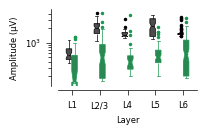

In [ ]:
FIG_SIZE = (1.8, 1)

fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)

ax = sns.boxplot(
    ax=ax,
    data=plot_data,
    x="layer",
    y="amplitude",
    hue="experiment",
    notch=True,
    hue_order=[
        "Dense (Horvath)",
        "Dense (Biophy. spontaneous)",
    ],
    palette=[COLOR_HV, COLOR_HS],
    width=0.4,
    linewidth=0.5,
    flierprops={
        "marker": ".",
        "markersize": 3,
    },
)

ax.set_yscale("log")

# axes
ax.spines[["top", "right"]].set_visible(False)
ax.legend("", frameon=False)

# disconnect axes (R style)
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))

# minor ticks
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=np.arange(0, 1.1, 0.1),
    numticks=10,
)
ax.tick_params(which="both")
ax.yaxis.set_minor_locator(locmin)

# labels
ax.set_ylabel("Amplitude (\u03bcV)")
ax.set_xlabel("Layer")

# customize the boxplot
p = 0
for box in ax.patches:
    if box.__class__.__name__ == "PathPatch":
        # a list item for each layer group
        if p in [0, 1, 2, 3, 4]:
            box.set_edgecolor(cl["COLOR_HV"])
            # Each box has 6 associated Line2D objects
            # (to make the whiskers, fliers, etc.)
            # Loop over them here, and use the same colour
            # as above
            # group 1 (HV)
            for k in range(6 * p, 6 * (p + 1)):
                ax.lines[k].set_color(cl["COLOR_HV"])  # box
                ax.lines[k].set_mfc(cl["COLOR_HV"])  # whisker
                ax.lines[k].set_mec(cl["COLOR_HV"])  # fliers
            p += 1
        elif p in [5, 6, 7, 8, 9]:
            # group 2 (HS)
            box.set_edgecolor(cl["COLOR_HS"])
            for k in range(6 * p, 6 * (p + 1)):
                ax.lines[k].set_color(cl["COLOR_HS"])
                ax.lines[k].set_mfc(cl["COLOR_HS"])
                ax.lines[k].set_mec(cl["COLOR_HS"])
            p += 1


## save figures
if SAVE_FIG:
    plt.savefig(
        "figures/0_validation/3_amplitude/fig2O/fig2O_horv.svg",
        bbox_inches="tight",
        **savefig_cfg
    )

## Statistics

### H0: Horvath median amplitude is the same across layers - No

Dunn's test
* Layer 2/3 is different from L1
* Layer 4 is same as 2/3 (p=0.8)
* Layer 5 is same as 4 (p=0.2)
* Layer 6 is same as 5 (p=0.7)

In [6]:
def ci95(data):
    return 1.96 * np.nanstd(data) / np.sqrt(np.sum(~np.isnan(data)))

def get_medians_and_ci95(plot_data, exp, feature: str):
    layers = ["L1", "L2/3", "L4", "L5", "L6"]
    stats = ""
    for layer in layers:
        feature_data = plot_data[(plot_data.experiment==exp) & (plot_data.layer==layer)][feature]
        stats += f"{feature_data.median()} $\pm$ {np.round(ci95(feature_data),1)}, "
    print(stats)

In [10]:
amp.get_kk(plot_data, "Dense (Horvath)")

# perform Dunn's posthoc test using a holm-sidak correction for the p-values
# to identify the layer amplitudes that significantly deviate from others
amp.get_posthoc_dunn_holm_sidak(plot_data, "Dense (Horvath)")
get_medians_and_ci95(plot_data, "Dense (Horvath)", "amplitude")

H=102.501273104423, p=2.885512347319623e-21
N_L1 = 36 sites
N_L23 = 60 sites
N_L4 = 20 sites
N_L5 = 88 sites
N_L6 = 68 sites
551.5 $\pm$ 65.5, 2040.5 $\pm$ 171.0, 1436.0 $\pm$ 180.7, 2231.5 $\pm$ 191.7, 1516.0 $\pm$ 102.0, 


### H1: The model's median amplitude is the same across layers - No

Dunn's test
* Layer 2/3 is different from L1
* Layer 4 is same as 2/3 (p=0.9)
* Layer 5 is same as 4 (p=0.7)
* Layer 6 is same as 5 (p=0.9)

In [11]:
amp.get_kk(plot_data, "Dense (Biophy. spontaneous)")

# perform Dunn's posthoc test using a holm-sidak correction for the p-values
# to identify the layer amplitudes that significantly deviate from others
amp.get_posthoc_dunn_holm_sidak(plot_data, "Dense (Biophy. spontaneous)")
get_medians_and_ci95(plot_data,  "Dense (Biophy. spontaneous)", "amplitude")

H=33.64928258792054, p=8.793705657226139e-07
N_L1 = 37 sites
N_L23 = 64 sites
N_L4 = 32 sites
N_L5 = 88 sites
N_L6 = 76 sites
157.0418701171875 $\pm$ 116.5, 489.4987487792969 $\pm$ 172.9, 386.34442138671875 $\pm$ 227.9, 491.86962890625 $\pm$ 72.4, 566.923095703125 $\pm$ 144.8, 


## Are Models and in vivo data the same?

In [4]:
from scipy.stats import kruskal
import scikit_posthocs as sp


def count_sites(df, exp, layer):
    return len(df[(df["experiment"] == exp) & (df["layer"] == layer)])


def get_amplitude(df, exp, layer):
    return df[(df["experiment"] == exp) & (df["layer"] == layer)]["amplitude"].values


def get_kk_compare_exps(df, layer):
    """kruskall wallis test
    """
    h, p = kruskal(
        get_amplitude(df, "Dense (Horvath)", layer),
        get_amplitude(df, "Dense (Biophy. spontaneous)", layer),
    )
    print(f"H={h}, p={p}")
    print(f"""N_H = {count_sites(df, "Dense (Horvath)", layer)} sites""")
    print(f"""N_DS = {count_sites(df, "Dense (Biophy. spontaneous)", layer)} sites""")
    
    
def get_posthoc_dunn_holm_sidak_compare_exps(plot_data, layer):
    """posthoc test after kruskall wallis with Dunn and holm_sidak
    multiple comparison correction of p-values

    Args:
        plot_data (_type_): _description_
        exp (_type_): _description_

    Returns:
        _type_: _description_
    """
    data = [
        get_amplitude(plot_data, "Dense (Horvath)", layer),
        get_amplitude(plot_data, "Dense (Biophy. spontaneous)", layer),
    ]
    # holm sidak method has more power than Bonferroni which is more conservative
    # Non-significance can indicate subtle differences, power issues, samll sample size,
    # or the balancing be due to how the Holm-Sidak correction controls Type I errors
    # while retaining power.
    # we can still look at the p-values to identify trends.
    df = sp.posthoc_dunn(data, p_adjust="holm-sidak")
    df.columns = ["Dense (Horvath)", "Dense (Biophy. spontaneous)"]
    df.index = ["Dense (Horvath)", "Dense (Biophy. spontaneous)"]
    return df


def get_posthoc_dunn_holm_sidak_compare_exps_l5(plot_data, layer):
    """posthoc test after kruskall wallis with Dunn and holm_sidak
    multiple comparison correction of p-values

    Args:
        plot_data (_type_): _description_
        exp (_type_): _description_

    Returns:
        _type_: _description_
    """
    data = [
        get_amplitude(plot_data, "Dense (Horvath)", layer),
        get_amplitude(plot_data, "Dense (Biophy. spontaneous)", layer),
    ]
    # holm sidak method has more power than Bonferroni which is more conservative
    # Non-significance can indicate subtle differences, power issues, samll sample size,
    # or the balancing be due to how the Holm-Sidak correction controls Type I errors
    # while retaining power.
    # we can still look at the p-values to identify trends.
    df = sp.posthoc_dunn(data, p_adjust="holm-sidak")
    df.columns = ["Dense (Horvath)", "Dense (Biophy. spontaneous)"]
    df.index = ["Dense (Horvath)", "Dense (Biophy. spontaneous)"]
    return df

In [5]:
print("------LAYER 1:------\n")

# kruskall-wallis
# perform Dunn's posthoc test using a holm-sidak correction for the p-values
# to identify the layer amplitudes that significantly deviate from others
get_kk_compare_exps(plot_data, "L1")
display(get_posthoc_dunn_holm_sidak_compare_exps(plot_data, "L1"))


print("\n------LAYER 2/3:------\n")

get_kk_compare_exps(plot_data, "L2/3")
display(get_posthoc_dunn_holm_sidak_compare_exps(plot_data, "L2/3"))

print("\n------LAYER 4:------\n")

get_kk_compare_exps(plot_data, "L4")
display(get_posthoc_dunn_holm_sidak_compare_exps(plot_data, "L4"))

print("\n------LAYER 5:------\n")

get_kk_compare_exps(plot_data, "L5")
display(get_posthoc_dunn_holm_sidak_compare_exps_l5(plot_data, "L5"))

print("\n------LAYER 6:------\n")

get_kk_compare_exps(plot_data, "L6")
display(get_posthoc_dunn_holm_sidak_compare_exps(plot_data, "L6"))

------LAYER 1:------

H=16.397745044614204, p=5.134627759664657e-05
N_H = 36 sites
N_DS = 37 sites


,Dense (Horvath),Dense (Biophy. spontaneous)
Dense (Horvath),1.000000,0.000051
Dense (Biophy. spontaneous),0.000051,1.000000



------LAYER 2/3:------

H=70.64446965441161, p=4.2776517170383007e-17
N_H = 60 sites
N_DS = 64 sites


,Dense (Horvath),Dense (Biophy. spontaneous)
Dense (Horvath),1.000000e+00,4.277652e-17
Dense (Biophy. spontaneous),4.277652e-17,1.000000e+00



------LAYER 4:------

H=26.559905660377353, p=2.5549135018417206e-07
N_H = 20 sites
N_DS = 32 sites


,Dense (Horvath),Dense (Biophy. spontaneous)
Dense (Horvath),1.000000e+00,2.554914e-07
Dense (Biophy. spontaneous),2.554914e-07,1.000000e+00



------LAYER 5:------

H=120.43718715921881, p=5.074845580472334e-28
N_H = 88 sites
N_DS = 88 sites


,Dense (Horvath),Dense (Biophy. spontaneous)
Dense (Horvath),1.000000e+00,5.074846e-28
Dense (Biophy. spontaneous),5.074846e-28,1.000000e+00



------LAYER 6:------

H=65.60343678180439, p=5.514251849255849e-16
N_H = 68 sites
N_DS = 76 sites


,Dense (Horvath),Dense (Biophy. spontaneous)
Dense (Horvath),1.000000e+00,5.514252e-16
Dense (Biophy. spontaneous),5.514252e-16,1.000000e+00


### H1: The model amplitudes are same as Horvath's - no

In [9]:
print("\nlayer 1\n")
amp.get_mwu(plot_data, "Dense (Horvath)", "Dense (Biophy. spontaneous)", "L1")

print("\nlayer 2/3\n")
amp.get_mwu(plot_data, "Dense (Horvath)", "Dense (Biophy. spontaneous)", "L2/3")

print("\nlayer 4\n")
amp.get_mwu(plot_data, "Dense (Horvath)", "Dense (Biophy. spontaneous)", "L4")

print("\nlayer 5\n")
amp.get_mwu(plot_data, "Dense (Horvath)", "Dense (Biophy. spontaneous)", "L5")

print("\nlayer 6\n")
amp.get_mwu(plot_data, "Dense (Horvath)", "Dense (Biophy. spontaneous)", "L6")


layer 1

1 vs. 2, z=1033.0, p=3.012698404397808e-05, N_1=36, N_2=37

layer 2/3

1 vs. 2, z=3601.0, p=1.6027256655012695e-21, N_1=60, N_2=64

layer 4

1 vs. 2, z=594.0, p=9.580662447086689e-09, N_1=20, N_2=32

layer 5

1 vs. 2, z=7582.0, p=4.850676145614261e-40, N_1=88, N_2=88

layer 6

1 vs. 2, z=4608.0, p=8.939574568918484e-19, N_1=68, N_2=76
